In [12]:
import jieba
import numpy as np
import pandas as pd
import pickle
from util_text_cleaner.text_cleaner import TextCleaner
from util_model.model_helper import FeatureKBest

# Check Word2Vec Model Result

Belows are some examples of the similar terms in our pre-trained word2vector model.

In [21]:
from gensim.models import Word2Vec
model300 = Word2Vec.load("result/word2vec_result/word2vec.model300")

In [442]:
model300.wv.most_similar('彭淮南', topn=5)

[('彭總裁', 0.7710217237472534),
 ('央行', 0.729074239730835),
 ('張盛和', 0.7097881436347961),
 ('財政部長', 0.6743882894515991),
 ('中央銀行', 0.6690319180488586)]

In [443]:
model300.wv.most_similar('房價', topn=5)

[('屋價', 0.7838715314865112),
 ('房地價', 0.6767888069152832),
 ('土地價格', 0.6736090779304504),
 ('房市', 0.672882616519928),
 ('物價', 0.6563156247138977)]

In [444]:
model300.wv.most_similar('看衰', topn=5)

[('唱衰', 0.8339731693267822),
 ('看壞', 0.798155665397644),
 ('看空', 0.7457432746887207),
 ('唱雖', 0.7350273728370667),
 ('唱空', 0.6866986155509949)]

In [445]:
model300.wv.most_similar('飆漲', topn=5)

[('飛漲', 0.8241196870803833),
 ('狂飆', 0.7983549237251282),
 ('飆升', 0.7962146997451782),
 ('上漲', 0.7787458300590515),
 ('狂漲', 0.769774854183197)]

# Check xgb model result 

Below are the performance of xgb model on test set. The model achieves a weighted F1 score of 0.72 and an accuracy of 0.72.

In [446]:
# Read model
filename = 'result/model_result/xgb_model.pkl'
xgb_model = pickle.load(open(filename, 'rb'))

In [448]:
# Make prediction on the test set
test = pd.read_pickle('data/test_data.pkl')
y_test = test['label']
y_pred = xgb_model.predict(test)

Generate Word2Vector features.
Finished.
Generate 3000 KBest features.
Finished.


In [449]:
from sklearn.metrics import f1_score, confusion_matrix

# check model performance on the test set
f1 = f1_score(y_test, y_pred, average = 'weighted')
accu = f1_score(y_test, y_pred, average = 'micro')
print(f'f1 : {f1}')
print(f'accuracy : {accu}')

f1 : 0.7195948622900562
accuracy : 0.7237087741132545


In [450]:
# check the confusion matrix result
## The confusion matrix shows that while the model is good at seperating negative and positive sentiments, 
## the performance of seperating netrual and positive/negative sentiments can be improved.
cm = confusion_matrix(y_test, y_pred)
cm

array([[251, 114,  36],
       [ 67, 671,  61],
       [ 64, 102, 241]])

In [451]:
# Demo the predicted result of negative sentiment
test[y_pred == 0].sample(1)['content'].values

array(['千萬不要買台灣房地產已經負成長了高雄又是人口負成長的前段班有錢人再撐沒錢人也在撐如果不是急著買屋真的不急用薪水來買現在的屋是最笨的現在薪水那麼低年輕人大部分都是沒能力購屋的一群買下去等著跌而已不是自己的錢不怕跌的就買而已'],
      dtype=object)

In [458]:
# Demo the predicted result of positive sentiment
test[y_pred == 2].sample(1)['content'].values

array([' 昨天開車去康橋周邊和龜山區的新重劃區繞了一圈，康橋鷹架已經全部拆除，正在整四周的退縮部分，已接近完工。Morrison 則剛剛架起第一棟的鋼構，順道去看一下一戶9000萬的別墅，外觀特別。A7周圍重劃區，靠文化一路左邊架起不少建案的大型廣告看板和接待中心，右邊則是幾家公司總部正在整地施工，中華郵政那塊地大的不像話，區域還沒有看過單一開案發地那麼大的。整個A7周邊看起來氣氛熱絡，未來榮景可期  '],
      dtype=object)

# Implement the model to the posts in forum of Taipei City

In [10]:
# read data
taipei = pd.read_pickle('data/taipei.pkl')

In [11]:
# Clean text and generate cut and corpus
tc = TextCleaner()
taipei['content_cleaned'] = tc.clean_text(taipei['content'].astype(str))
taipei['cut'], taipei['corpus'] = tc.lcut_to_corpus(taipei['content_cleaned'])

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/l6/6gclw8gd309_xq4q2s1hzmz40000gn/T/jieba.cache
Loading model cost 0.483 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/gogolook/house_market_sentiment_analysis/util_text_cleaner/dict.txt ...
Loading model from cache /var/folders/l6/6gclw8gd309_xq4q2s1hzmz40000gn/T/jieba.u1e159fae52356dba817fc578c7433c43.cache
Loading model cost 0.874 seconds.
Prefix dict has been built successfully.


In [13]:
# Generate 1 - 5 gram cut
f_kb = FeatureKBest(k = 3000)
taipei['n_gram_cut'] = f_kb.gen_gram_cut(taipei['content_cleaned'], max_n = 5)

In [19]:
# Make predictions
taipei['pred'] = xgb_model.predict(taipei)

Generate Word2Vector features.


/Users/gogolook/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gogolook/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Finished.
Generate 3000 KBest features.
Finished.


# Evaluate results

In this section, I compute sentiment ratios for different quarters, where <br>
$$ \text{Sentiment Ratio} = \frac{\text{Positive Sentiment} - \text{Negative Sentiment}}{\text{Positive Sentiment} + \text{Negative Sentiment}} $$, is obtained by comparing positive to negative sentiment counts. <br>

Subsequently, I correlate these sentiment ratios with house prices in Taipei from 2009 to 2018. The house price data is sourced from [Sinyi Realty (信義房屋)](https://www.sinyinews.com.tw/quarterly?sinyisid=MjAyMzA4MTQxMTMxNTAzMTg=), which specifically focuses on residential property transactions. It provides one of the most representive house price index in Taiwan.

In [265]:
# Generate quarter column 
taipei['post_time'] = pd.to_datetime(taipei['post_time'])
taipei['yq'] = taipei['post_time'].dt.to_period('Q')

In [142]:
# (map predicted result to {0:-1(depreciation), 1:0(Neutral), 2:1(Appreciation)})
taipei['pred'] = taipei['pred'] - 1 

In [462]:
# calculate the general sentiment of taipei house market
t1 = taipei.groupby(['yq']).agg(
                                    total_counts = ('pred', lambda x : len(x))
                                    , postive_counts = ('pred', lambda x : np.sum(x==1))
                                    , negative_counts = ('pred', lambda x : np.sum(x==-1))
                                    , sentiment = ('pred', lambda x: np.sum(x)*1.0 / np.sum(np.abs(x)))
                                ).reset_index()
t1['yq'] = t1['yq'].astype(str)
t1

,yq,total_counts,postive_counts,negative_counts,sentiment
0,2007Q4,32,3,1,0.500000
1,2008Q1,287,57,19,0.500000
2,2008Q2,421,41,12,0.547170
3,2008Q3,1536,146,229,-0.221333
4,2008Q4,1902,137,191,-0.164634
5,2009Q1,3428,229,275,-0.091270
6,2009Q2,5309,475,286,0.248357
7,2009Q3,7826,573,377,0.206316
8,2009Q4,7705,620,422,0.190019
9,2010Q1,8497,747,666,0.057325


In [299]:
# load the price data
price = pd.read_csv('data/sinyi_price.csv')
taipei_price = price[price['county_eng'] == 'Taipei City']
taipei_price.head()

,county_eng,county,year,quarter,yq,sinyi_price
0,Taichung City,台中市,2009,1,2009Q1,9.622155
1,Taichung City,台中市,2009,2,2009Q2,10.453284
2,Taichung City,台中市,2009,3,2009Q3,11.200537
3,Taichung City,台中市,2009,4,2009Q4,11.645966
4,Taichung City,台中市,2010,1,2010Q1,11.987186


In [468]:
# merge price and sentiment ratio
t1 = pd.merge(t1, taipei_price, on = 'yq', how='left')

# Because the number of posts in '2007Q4', '2008Q1', '2008Q2' is lower than 500, which could affects their representive. I'd like to draw them with dash line.  
t1['sentiment_dash'] = np.where(t1['yq'].isin(['2007Q4', '2008Q1', '2008Q2', '2008Q3']), t1['sentiment'], np.nan )
t1['sentiment_not_dash'] = np.where(t1['yq'].isin(['2007Q4', '2008Q1', '2008Q2']),np.nan, t1['sentiment'] )

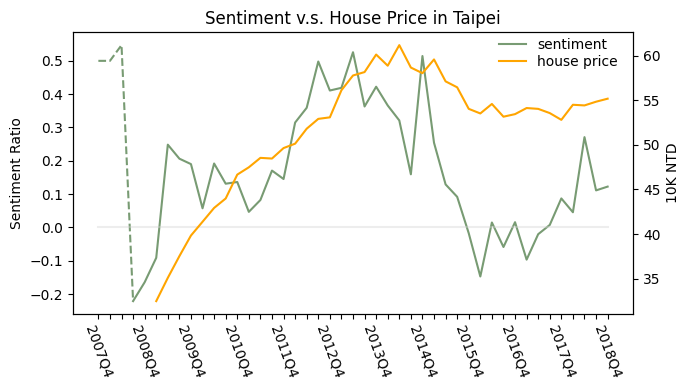

In [474]:
import matplotlib.pyplot as plt

# create figure and subplot
fig = plt.figure(figsize=(7, 4))
ax1 = fig.add_subplot()

# Create the first plot on the left y-axis
ax1.plot(t1['yq'], t1['sentiment_not_dash'], color= '#789b73', label='sentiment')
ax1.plot(t1['yq'], t1['sentiment_dash'], color= '#789b73', linestyle='--')
ax1.plot(t1['yq'], [0]*len(t1), color= 'lightgray', alpha = 0.4)

# Create a twin axes sharing the x-axis
ax2 = plt.gca().twinx()

# Create the second plot on the right y-axis
ax2.plot(t1['yq'], t1['sinyi_price'], color='orange', label='house price')

# set y label
ax1.set_ylabel('Sentiment Ratio')
ax2.set_ylabel('10K NTD')

# set legend
ax1.legend(loc = [0.75,0.91], frameon=False)
ax2.legend(loc = [0.75,0.85], frameon=False)

# set x-axis
ax1.tick_params(axis='x', rotation=290)
every_nth = 4
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
# Add title
plt.title("Sentiment v.s. House Price in Taipei")
plt.tight_layout()

This figure shows housing prices and sentiments in Taipei between 2008 and 2018. <br> <br> 
Before 2015, the public were largely positive. However, between 2015 and 2016, the morale of the housing market started slumping. This pessimistic sentiment persisted until late 2017. At first glance, the patterns of the house prices and the sentiments seem correlated. The house prices grew exponentially before 2014 but have stagnated since 2014. __This apparent alignment suggests a potential relationship between house prices and public sentiments in Taipei.__ However, a more rigorous examination still has to be done to make any further causal inferences.

In [475]:
fig.savefig('plot/sentiment_and_price_in_taipei.png')